### Tiền xử lý dữ liệu ###

In [ ]:
#chung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score, log_loss, confusion_matrix
from sklearn.utils import class_weight, resample
from tensorflow.keras import layers, models, losses, optimizers, metrics
#1
from sklearn.linear_model import LogisticRegression
#2
from sklearn.neighbors import KNeighborsClassifier
#3
from sklearn.naive_bayes import GaussianNB
#4
from sklearn.svm import SVC
#5
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
#6
from sklearn.ensemble import RandomForestClassifier
#7
from sklearn.neural_network import MLPClassifier
#8
import xgboost as xgb

# 1. Load & preprocess
df = pd.read_csv('/content/Churn_Modelling.csv')
X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = df['Exited']

# 3) Upsample minority (Exited=1)
df_combined = pd.concat([X, y], axis=1)
df_majority = df_combined[df_combined.Exited == 0]
df_minority = df_combined[df_combined.Exited == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

X_bal = df_balanced.drop("Exited", axis=1)
y_bal = df_balanced["Exited"]

# 4) Preprocessing pipeline
categorical_features = ["Geography", "Gender"]
numerical_features = [c for c in X_bal.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

X_proc = preprocessor.fit_transform(X_bal)
'''
# Identify column types
num_cols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']
cat_cols = ['Geography','Gender']
'''
'''
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='if_binary'), cat_cols)
])

X_proc = preprocessor.fit_transform(X)
'''
# 2. Train/test split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y_bal, test_size=0.2, random_state=42
)

### 1. Logistic Regression ###
GridSearch (C);
penalty = l2;
class_weight = 'balanced';
max_iter = 1000

Fitting 5 folds for each of 8 candidates, totalling 40 fits
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1605
           1       0.71      0.69      0.70      1581

    accuracy                           0.71      3186
   macro avg       0.71      0.71      0.71      3186
weighted avg       0.71      0.71      0.71      3186

AUC-ROC: 0.7722873452466104
Log Loss: 0.5753395875195694


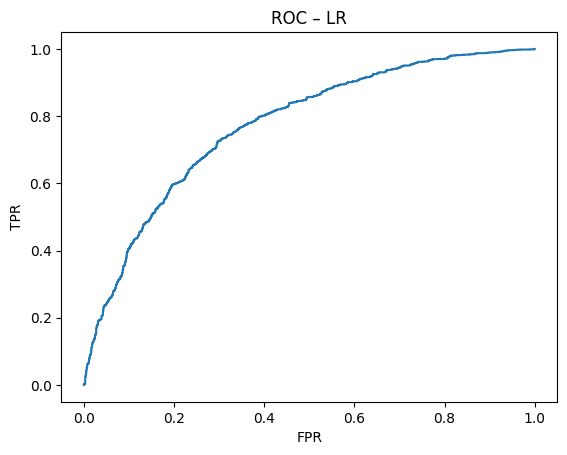

In [ ]:
pipe = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000)

param_grid= {
    'C':[0.01,0.1,1,10],
    'penalty': ['l1','l2']
}

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)
model1 = grid.best_estimator_

# Phần đánh giá
y_pred = model1.predict(X_test)
y_proba = model1.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
loss = log_loss(y_test, y_proba)
print("Log Loss:", loss)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title("ROC – LR")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

### 2. K-Nearest Neighbors ###

→ Best Parameters: {'n_neighbors': 21, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      1605
           1       0.82      0.99      0.90      1581

    accuracy                           0.89      3186
   macro avg       0.90      0.89      0.89      3186
weighted avg       0.90      0.89      0.89      3186

→ AUC-ROC: 0.9912741058638308
→ Log Loss: 0.30580327583173966


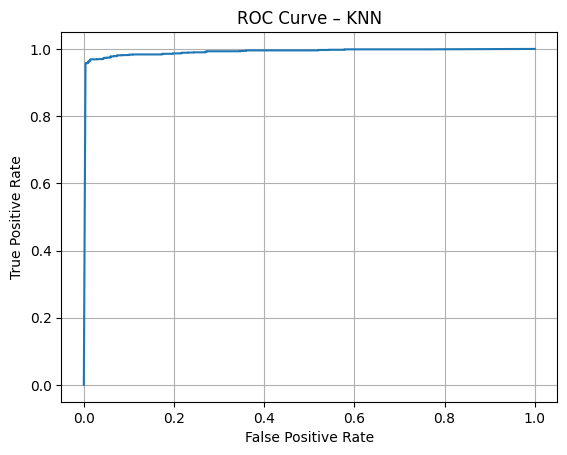

'\n# 8. Confusion Matrix\nconf = confusion_matrix(y_test, y_pred)\nsns.heatmap(conf, annot=True, fmt=\'d\', cmap=\'Blues\')\nplt.title("Confusion Matrix – KNN")\nplt.xlabel("Predicted")\nplt.ylabel("Actual")\nplt.show()\n'

In [ ]:
# 5. Tối ưu mô hình KNN
params = {'n_neighbors': [3, 5, 7, 9, 11, 15, 21], 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, params, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
model2 = grid.best_estimator_

# 6. Đánh giá
y_pred = model2.predict(X_test)
y_proba = model2.predict_proba(X_test)[:, 1]

print("→ Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred))
print("→ AUC-ROC:", roc_auc_score(y_test, y_proba))
print("→ Log Loss:", log_loss(y_test, y_proba))

# 7. Biểu đồ ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title("ROC Curve – KNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()
'''
sns.histplot(y_proba, bins=20, kde=True)
plt.title("Phân phối xác suất dự đoán (KNN)")
plt.xlabel("Xác suất dự đoán Exited = 1")
plt.show()
'''
'''
# 8. Confusion Matrix
conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
'''

### 3.Naive Bayes ###

Best var_smoothing: 1e-12
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72      1605
           1       0.72      0.70      0.71      1581

    accuracy                           0.72      3186
   macro avg       0.72      0.72      0.72      3186
weighted avg       0.72      0.72      0.72      3186

AUC-ROC: 0.7908725303004329
Log Loss: 0.5534575856912751


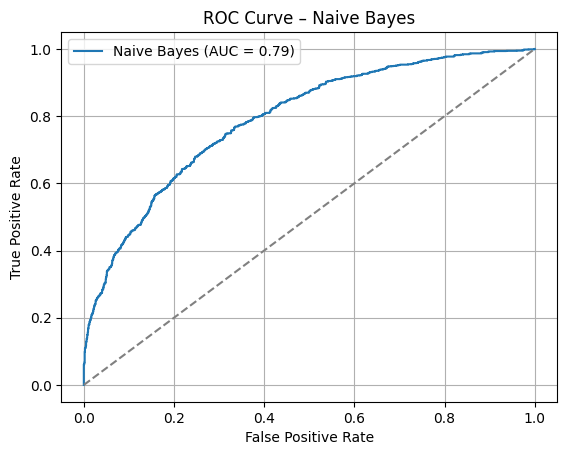

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# 1. Tối ưu hóa với MinMaxScaler (Naive Bayes hoạt động tốt với dữ liệu chuẩn hóa)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Tối ưu siêu tham số var_smoothing
param_grid = {'var_smoothing': np.logspace(-12, -6, 30)}
grid = GridSearchCV(GaussianNB(), param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# 3. Mô hình tốt nhất
model_nb = grid.best_estimator_

# 4. Dự đoán
y_pred = model_nb.predict(X_test_scaled)
y_proba = model_nb.predict_proba(X_test_scaled)[:, 1]

# 5. Đánh giá mô hình
print("Best var_smoothing:", grid.best_params_['var_smoothing'])
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
print("Log Loss:", log_loss(y_test, y_proba))

# 6. Vẽ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label="Naive Bayes (AUC = {:.2f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Naive Bayes")
plt.legend()
plt.grid()
plt.show()


### 4. SVM ###

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1605
           1       0.82      0.85      0.83      1581

    accuracy                           0.83      3186
   macro avg       0.83      0.83      0.83      3186
weighted avg       0.83      0.83      0.83      3186

AUC-ROC: 0.9078811667366172
Log Loss: 0.3874119840125917


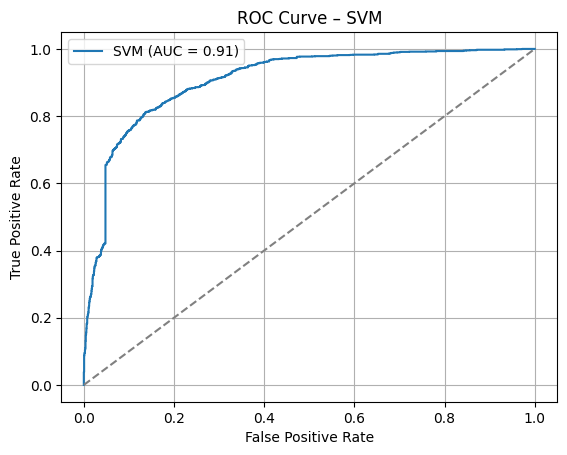

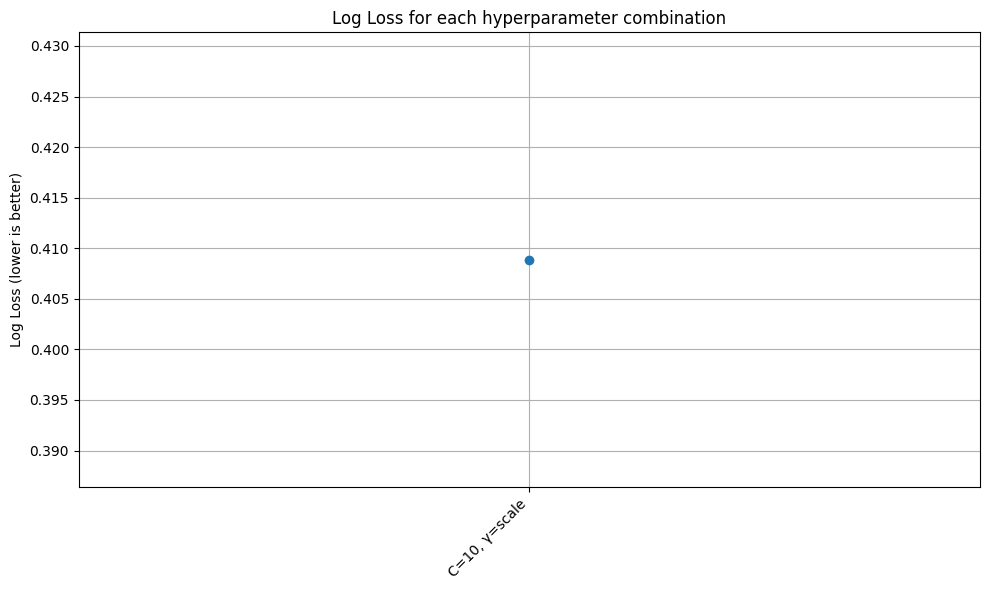

In [ ]:
# GridSearchCV để tối ưu SVM
params = {
    #'C': [0.1, 1, 10],
    #'gamma': ['scale', 0.1, 0.01],
    'C': [10],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=params,
    scoring='neg_log_loss',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    return_train_score=True,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Gán mô hình tốt nhất vào biến model4
model4 = grid.best_estimator_

# Dự đoán
y_pred = model4.predict(X_test)
y_proba = model4.predict_proba(X_test)[:, 1]

# Đánh giá
print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
print("Log Loss:", log_loss(y_test, y_proba))

# Biểu đồ ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label="SVM (AUC = {:.2f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SVM")
plt.legend()
plt.grid()
plt.show()

# Biểu đồ log loss theo từng mô hình
results = grid.cv_results_
log_losses = -results['mean_test_score']
param_labels = [f"C={p['C']}, γ={p['gamma']}" for p in results['params']]

plt.figure(figsize=(10, 6))
plt.plot(range(len(log_losses)), log_losses, marker='o')
plt.xticks(range(len(log_losses)), param_labels, rotation=45, ha='right')
plt.ylabel("Log Loss (lower is better)")
plt.title("Log Loss for each hyperparameter combination")
plt.grid()
plt.tight_layout()
plt.show()


### 5. Decision tree###

→ Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1605
           1       0.71      0.69      0.70      1581

    accuracy                           0.71      3186
   macro avg       0.71      0.71      0.71      3186
weighted avg       0.71      0.71      0.71      3186

→ AUC-ROC: 0.7721178874524385
→ Log Loss: 0.5752212283370332


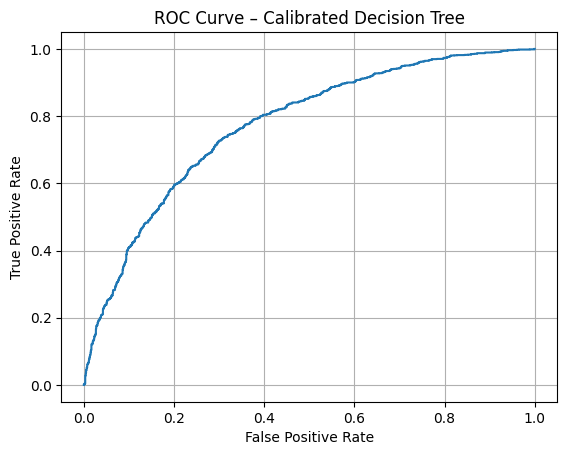

'\n# 6. Confusion Matrix\nconf = confusion_matrix(y_test, y_pred)\nsns.heatmap(conf, annot=True, fmt=\'d\', cmap=\'Blues\')\nplt.title("Confusion Matrix (Calibrated)")\nplt.xlabel("Predicted")\nplt.ylabel("Actual")\nplt.show()\n'

In [ ]:
# 1. Huấn luyện DecisionTree với GridSearch
params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

dtree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(dtree, params, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("→ Best Parameters:", grid.best_params_)

# 2. Calibration
model5 = CalibratedClassifierCV(method='sigmoid', cv=5)
model5.fit(X_train, y_train)

# 3. Predict
y_proba = model5.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

# 4. Đánh giá
print(classification_report(y_test, y_pred))
print("→ AUC-ROC:", roc_auc_score(y_test, y_proba))
print("→ Log Loss:", log_loss(y_test, y_proba))

# 5. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title("ROC Curve – Calibrated Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()
'''
# 6. Confusion Matrix
conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Calibrated)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
'''

### 6. Random forest ###
class_weight = 'balanced', gridsearchCV

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1605
           1       0.92      0.98      0.95      1581

    accuracy                           0.95      3186
   macro avg       0.95      0.95      0.95      3186
weighted avg       0.95      0.95      0.95      3186

AUC-ROC: 0.9914934157765207
Log Loss: 0.168050465482955


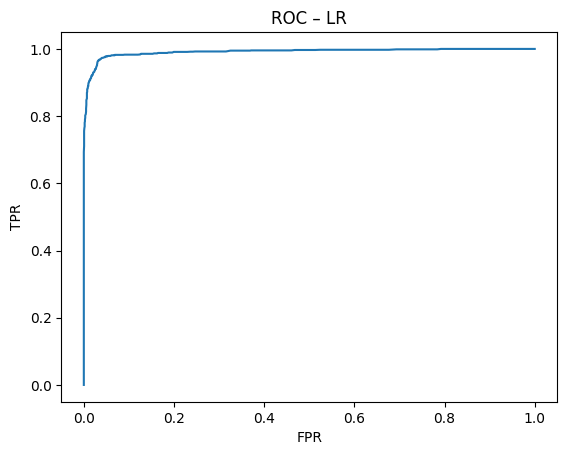

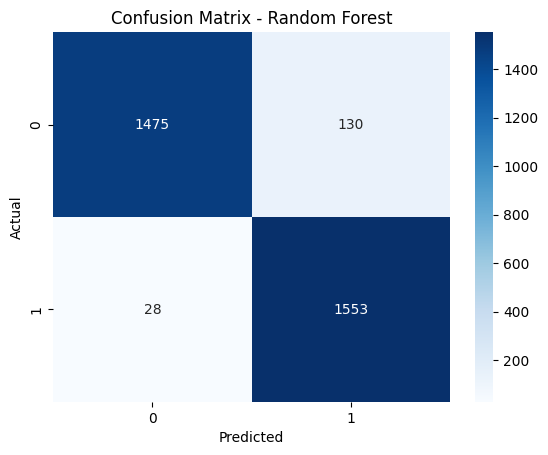

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
pipe = RandomForestClassifier(class_weight='balanced', random_state=42)
params = {
    'n_estimators':[100,200,300],
    'max_depth':[None,10,20],
    'min_samples_leaf':[1,3,5]
}
grid = GridSearchCV(pipe, params,
                    cv=StratifiedKFold(5),
                    scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
model6 = grid.best_estimator_

# Phần đánh giá giống hệt trên
# Đánh giá trên X_test, y_test
y_pred = model6.predict(X_test)
y_proba = model6.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
loss = log_loss(y_test, y_proba)
print("Log Loss:", loss)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title("ROC – LR")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()
plt.figure()

# Ma trận nhầm lẫn
conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_test_series = pd.Series(y_test, index=X_test_raw.index)
y_pred_series = pd.Series(y_pred, index=X_test_raw.index)
fp_idx = y_test_series[(y_test_series == 0) & (y_pred_series == 1)].index

# 4. Lấy mẫu FP gốc
fp_samples_raw = X_test_raw.loc[fp_idx].copy()
fp_samples_raw['Actual'] = y_test_series.loc[fp_idx]
fp_samples_raw['Predicted'] = y_pred_series.loc[fp_idx]

# 5. Hiển thị
print("Các mẫu False Positive (dữ liệu gốc):")
print(fp_samples_raw.head())



###7. Neural Network###
class weight = 'balanced'; Dropout; Normalization; Adam

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6265 - loss: 0.6579 - val_accuracy: 0.7527 - val_loss: 0.5043
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7432 - loss: 0.5160 - val_accuracy: 0.7885 - val_loss: 0.4548
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7535 - loss: 0.4979 - val_accuracy: 0.7841 - val_loss: 0.4444
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7603 - loss: 0.4851 - val_accuracy: 0.7967 - val_loss: 0.4391
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7695 - loss: 0.4768 - val_accuracy: 0.7826 - val_loss: 0.4447
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7651 - loss: 0.4792 - val_accuracy: 0.7983 - val_loss: 0.4319
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7701 - loss: 0.4733 - val_accuracy: 0.7896 - val_loss: 0.4403
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7795 - loss: 0.4640 - val_accuracy: 0.

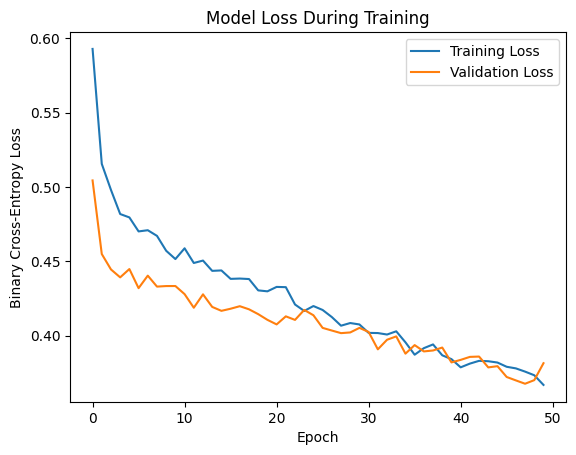

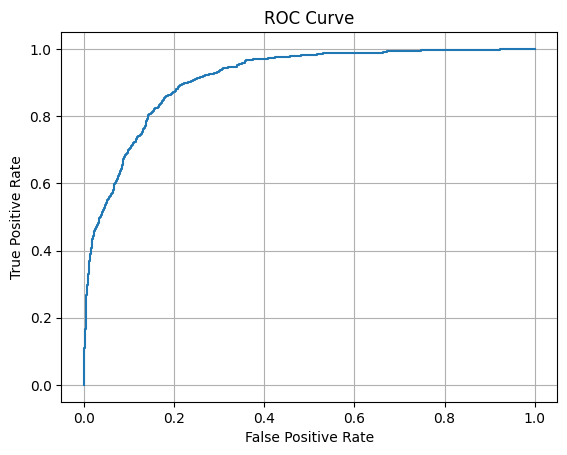

In [ ]:
cw = class_weight.compute_class_weight('balanced',
                                       classes=np.unique(y_train),
                                       y=y_train)
cw_dict = dict(enumerate(cw))

model7 = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(), layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(), layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(), layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model7.compile(optimizer=optimizers.Adam(),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model7.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50, batch_size=32,
                    class_weight=cw_dict,
                    verbose=1)

# Đánh giá như trên

y_proba = model7.predict(X_test).flatten()
y_pred = (y_proba>0.5).astype(int)
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Model Loss During Training')
plt.legend()
plt.show()

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

###8. XGBoost###

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:27:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


→ Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1605
           1       0.90      0.98      0.93      1581

    accuracy                           0.93      3186
   macro avg       0.93      0.93      0.93      3186
weighted avg       0.94      0.93      0.93      3186

→ AUC-ROC: 0.9761762045789072
→ Log Loss: 0.20088167638260782


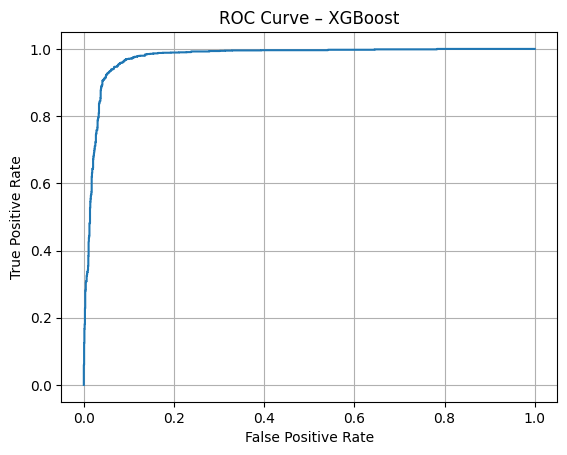

'\n# 5. Confusion Matrix\nconf = confusion_matrix(y_test, y_pred)\nsns.heatmap(conf, annot=True, fmt=\'d\', cmap=\'Blues\')\nplt.title("Confusion Matrix – XGBoost")\nplt.xlabel("Predicted")\nplt.ylabel("Actual")\nplt.show()\n'

In [ ]:
# 1. Khởi tạo mô hình XGBoost với class_weight thay thế bằng scale_pos_weight
# scale_pos_weight = (số lượng lớp 0 / số lượng lớp 1)
ratio = (y_train == 0).sum() / (y_train == 1).sum()
model8 = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# 2. Grid Search tham số
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(model8, params, scoring='roc_auc', cv=StratifiedKFold(5), n_jobs=-1)
grid.fit(X_train, y_train)

# 3. Dự đoán và đánh giá
model8 = grid.best_estimator_ #best model
y_proba = model8.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

print("→ Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred))
print("→ AUC-ROC:", roc_auc_score(y_test, y_proba))
print("→ Log Loss:", log_loss(y_test, y_proba))

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title("ROC Curve – XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()
'''
# 5. Confusion Matrix
conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
'''

###Test###

In [ ]:

# Nhập thông tin từ người dùng
def get_user_input():
    print("Nhập thông tin khách hàng mới để dự đoán (Exited hoặc Không):")
    data = {
        'CreditScore': int(input("Credit Score (300–850): ")),
        'Geography': input("Geography (France/Germany/Spain): "),
        'Gender': input("Gender (Male/Female): "),
        'Age': int(input("Age: ")),
        'Tenure': int(input("Tenure (số năm đã dùng dịch vụ): ")),
        'Balance': float(input("Balance (số dư tài khoản): ")),
        'NumOfProducts': int(input("Số lượng sản phẩm sử dụng: ")),
        'HasCrCard': int(input("Có thẻ tín dụng không? (1: Có, 0: Không): ")),
        'IsActiveMember': int(input("Là thành viên hoạt động không? (1: Có, 0: Không): ")),
        'EstimatedSalary': float(input("Estimated Salary (lương ước tính): "))
    }
    return pd.DataFrame([data])

# Lấy dữ liệu từ người dùng
new_customer = get_user_input()

# Tiền xử lý dữ liệu
new_customer_proc = preprocessor.transform(new_customer)

# Dự đoán
proba = model6.predict(new_customer_proc).flatten()[0]
pred = int(proba > 0.5)

# In kết quả
print("\n Kết quả dự đoán:")
print("→ Xác suất rời bỏ dịch vụ (Exited = 1):", proba)
print("→ Dự đoán:", "Khách hàng sẽ rời bỏ" if pred else "Khách hàng sẽ ở lại")


Nhập thông tin khách hàng mới để dự đoán (Exited hoặc Không):
Credit Score (300–850): 619
Geography (France/Germany/Spain): France
Gender (Male/Female): Female
Age: 42
Tenure (số năm đã dùng dịch vụ): 2
Balance (số dư tài khoản): 0
Số lượng sản phẩm sử dụng: 1
Có thẻ tín dụng không? (1: Có, 0: Không): 1
Là thành viên hoạt động không? (1: Có, 0: Không): 1
Estimated Salary (lương ước tính): 101000

📊 Kết quả dự đoán:
→ Xác suất rời bỏ dịch vụ (Exited = 1): 1
→ Dự đoán: ❌ Khách hàng sẽ rời bỏ


### Program run ###

In [ ]:
from sklearn.pipeline import Pipeline
import pickle

full_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model6)
])

# Save pipeline
with open("model_pipeline.pkl", "wb") as f:
    pickle.dump(full_pipeline, f)
